## Stroke Prediction: 

The aim of this mini project is to build some familiarity with using cross validation data to compare models. I'll be building a model using the Stroke Prediction dataset found on Kaggle.

Importing Packages:

In [5]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import seaborn as sb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
pd.options.mode.chained_assignment = None
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE 


Import Data:

In [6]:
stroke_data = pd.read_csv('./Data/Stroke_Prediction_Dataset.csv')
stroke_data.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


#### Basic EDA and PreProcessing:

Firstly can drop the "id" columns as not needed:

In [7]:
stroke_data.drop(columns='id', inplace=True)

We have categorical data, hence for our model, should convert to numerical using an encoder, but first lets check prescence of null values.

In [8]:
stroke_data.isnull().sum(axis=0)

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

/Users/tajsmac/opt/miniconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


28.893236911794673


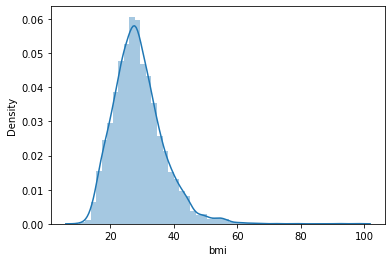

In [9]:
sb.distplot(stroke_data['bmi'])
print(stroke_data['bmi'].mean())

The distribution seems slightly skewed but approporiate for a mean impute. I'll now replace the missing values with the mean, this will keep the mean the same of the BMI series the same.

In [10]:
stroke_data['bmi'][stroke_data['bmi'].isnull()] = stroke_data['bmi'].mean()

stroke_data.isnull().sum(axis=0)

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [11]:
stroke_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Now to deal with the categorical Data:

The categories are: 

In [12]:
# Dictionary of categorical data, keys are the column names in the Dataframe, values are the nice/logical names.
categorical_data = {'gender' : 'Genders', 'ever_married' : 'MarriageStatusses',
                    'work_type' : 'Job Types', 'Residence_type' : 'Residencies', 
                    'smoking_status' : 'Smoking Statusses'}

In [13]:
gender_encoder = LabelEncoder()
married_encoder = LabelEncoder()
work_encoder = LabelEncoder()
residence_encoder = LabelEncoder()
smoking_encoder = LabelEncoder()

encoders = [gender_encoder, married_encoder, work_encoder, residence_encoder, smoking_encoder]

encoders_dict = {k: v for k in categorical_data.keys() for v in encoders}

In [14]:
for column, encoder in encoders_dict.items():
    stroke_data[column] = encoder.fit_transform(stroke_data[column])
    print(f'The {categorical_data[column]} are: {encoder.classes_}')
    print(f' The corresponding encoding used is: {encoder.transform(encoder.classes_)}')

The Genders are: ['Female' 'Male' 'Other']
 The corresponding encoding used is: [0 1 2]
The MarriageStatusses are: ['No' 'Yes']
 The corresponding encoding used is: [0 1]
The Job Types are: ['Govt_job' 'Never_worked' 'Private' 'Self-employed' 'children']
 The corresponding encoding used is: [0 1 2 3 4]
The Residencies are: ['Rural' 'Urban']
 The corresponding encoding used is: [0 1]
The Smoking Statusses are: ['Unknown' 'formerly smoked' 'never smoked' 'smokes']
 The corresponding encoding used is: [0 1 2 3]


In [15]:
stroke_data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


Now that we've dealt with the categorical data, we do another logical model improvement step: feature reduction. By reducing the number of features reduces the amount of computation needed to fit the model. I'll aim to remove: 

- Features based on collinearity with each other. In particular if 2 features are highly correlated then it's likely both influence whether a person has a stroke or not in the same way. Eg. we may find that age and avg_glucose_level are correlated.

Plot the Correlation Matrix: 

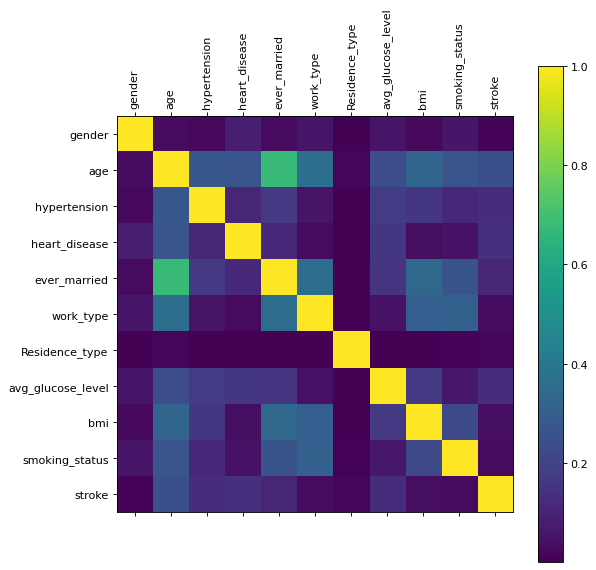

In [16]:
correlation_matrix = abs(stroke_data.corr())
plt.figure(figsize=(8,8), dpi=80)
plt.matshow(correlation_matrix, fignum=1)
plt.xticks(ticks=range(correlation_matrix.shape[0]), labels=correlation_matrix.columns, rotation='vertical')
plt.yticks(ticks=range(correlation_matrix.shape[0]), labels=correlation_matrix.columns, rotation='horizontal')
plt.colorbar()

From this it seems like none of the features are pairwise correlated hence it's worth keeping all features. 

Retrieve design matrix and labels vector:

In [17]:
stroke_data.head()
X = stroke_data.iloc[:, :-1]
y = stroke_data.iloc[:,-1]
dist = Counter(y)
print(dist)

Counter({0: 4861, 1: 249})


Based off the labels split, we see that the data is unevenly distributed to indiviudals who haven't had a stroke. ie, most of the labels are 0. Based on this observation we can expect that our model will be better at classifying indiviuals who are less likely to have a stroke.

To account for this, I'll use the "Synthetic Minority Oversampling Technique" to balance out the data.

In [19]:
sm = SMOTE(sampling_strategy="minority", random_state=40)
X_balanced, y_balanced = sm.fit_resample(X, y)
print(X_balanced.shape)
print(y_balanced.shape)

(9722, 10)
(9722,)
